# Финальный проект по теме "Промышленность"

**Цель**

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая сможет предсказать температуру стали.

**Описание**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**Задачи**

Необходимо провести исследовательский анализ данных.

Необходимо построить модель машиного обучения, которая предскажет температуру стали.

In [5]:
import pandas as pd
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as ltb
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV 
import shap

In [6]:
try:
    data_electrod = pd.read_csv('data_arc_new.csv')
    data_sip_volume = pd.read_csv('data_bulk_new.csv')
    data_sip_time = pd.read_csv('data_bulk_time_new.csv')
    data_gas = pd.read_csv('data_gas_new.csv')
    data_temp = pd.read_csv('data_temp_new.csv')
    data_wire_volume = pd.read_csv('data_wire_new.csv')
    data_wire_time = pd.read_csv('data_wire_time_new.csv')
except:
    data_electrod = pd.read_csv('/datasets/data_arc_new.csv')
    data_sip_volume = pd.read_csv('/datasets/data_bulk_new.csv')
    data_sip_time = pd.read_csv('/datasets/data_bulk_time_new.csv')
    data_gas = pd.read_csv('/datasets/data_gas_new.csv')
    data_temp = pd.read_csv('/datasets/data_temp_new.csv')
    data_wire_volume = pd.read_csv('/datasets/data_wire_new.csv')
    data_wire_time = pd.read_csv('/datasets/data_wire_time_new.csv')

In [7]:
# переводим все ячейки с датой и временем в формат datetime
data_temp['time'] = pd.to_datetime(data_temp['Время замера'])
data_temp = data_temp.drop(columns=['Время замера'], axis=1)
data_electrod['start_time'] = pd.to_datetime(data_electrod['Начало нагрева дугой'])
data_electrod['end_time'] = pd.to_datetime(data_electrod['Конец нагрева дугой'])
data_electrod = data_electrod.drop(columns=['Начало нагрева дугой'], axis=1)
data_electrod = data_electrod.drop(columns=['Конец нагрева дугой'], axis=1)

for col in data_sip_time.columns[1:]:
    data_sip_time[col] =  pd.to_datetime(data_sip_time[col])
for col in data_wire_time.columns[1:]:
    data_wire_time[col] =  pd.to_datetime(data_wire_time[col])

In [8]:
data_electrod['delta_t'] = data_electrod['end_time'] - data_electrod['start_time']
data_electrod['seconds'] = data_electrod['delta_t'].dt.total_seconds()
data_electrod = data_electrod.drop(columns=['delta_t'], axis=1)

In [9]:
data_electrod.describe()

**Вывод**

Отбросим отрицательные значения мощности.

In [10]:
data_electrod = data_electrod.loc[data_electrod['Реактивная мощность'] > 0]

In [11]:
data_electrod

In [12]:
len(data_electrod['key'].unique())

**Вывод по датасету data_electrod**

Была проведена предобработка данных, а также добавлен столбец со временем каждого этапа продувки, что возможно, пригодится впоследствии. Данные о начале и конце нагрева было решено оставить для дальнейшего их объединения.

In [13]:
data_sip_volume = data_sip_volume.fillna(0)

In [14]:
data_sip_volume

**Выводы по датасету data_sip_volume**

Датасет содержит информацию о различных добавках порошков для каждой партии продувки. Эти данные в дальейшем необходимо будет добавить в общий датасет, на данный момент были заполнены пропуски в значениях нулями.

In [15]:
data_gas

**Выводы по датасету data_gas**

Датасет содержит информацию об продувке газом, необходимо получить дополнительные данные о продувке газом на каждом этапе, даны только на первом.

In [16]:
data_wire_volume = data_wire_volume.fillna(0)

In [17]:
data_wire_volume

**Выводы по датасету data_wire_volume**

Датасет содержит информацию о различных добавках проволоки для каждой партии продувки. Эти данные в дальейшем необходимо будет добавить в общий датасет, на данный момент пропуски были заполнены нулями.

In [18]:
data_temp = data_temp.dropna()

In [19]:
len(data_temp['key'].unique())

In [20]:
data_temp

**Вывод по датасету data_temp**

Данный датасет содержит целевой признак, поэтому были удалены строки с пропусками.

In [21]:
data_sip_time

In [22]:
data_wire_time

**Вывод по датасетам data_wire_time и data_sip_time**

Данные датасеты содержат информацию о дате добавления того или иного легирующего элемента. По ним на данный момент не было предпринято никаких действий. Даты в добавлении почти совпадают с датой конца нагрева в датафрейме с электродами.

# Общий вывод

В ходе составления плана была проведена предварительная преодобработка данных, были удалены аномальные значения. Также в столбце с целевым значением были удалены пропуски.

Исходя из анализа данных был сделан вывод о том, что в таблицах, которые хранят значения о мощности электродов и температуре присутствует несколько записей из-за того, что для одного состава стали проводилось несколько добавлений модифицирющих веществ (легирований). В таблицах о проволочных материалах и присыпках содержится несколько столбцов о добавлении легирующих элементов для каждого этапа продувки (то есть каждый столбец с данными об объеме сыпучих материалов и проволоки соответствует строке записи в таблицах, содержащих значение температуры и мощности), эти значения возможно объединить по столбцу key.

# План работы

1) Объединить по столбцу key таблицы с реактивной мощностью, температурой, объемами проволоки и сыпучих материалов;

    1. Сделать предобработку данных в каждой таблице (удалить пропуски, дубликаты, удалить промежуточные значения температур);
    2. Выделить конечную и начальную запись с температурой в датафрейме с температурой и мощностью;
    3. Объединить таблицы с мощностью, температурой, добавками;

2) Подготовить данные для обучения;

    1. Выделить целевой признак, а также оформить признаки для обучения (провести масштабирование, удалить сильно скореллированные признаки);
    2. Разделить данные на тестовую и обучающу выборки;
    3. Обработать аномалии в обучающей выборке;
    4. На основе кросс-валидации создать модели машинного обучения и выбрать наилучшую по метрике MAE.

3) Далее выбрать лучшую модель и обучить ее на общей выборке;

    1. Выбранную модель протестировать на тестовой выборке;
    2. Оценить адекватность модели, сравнив ее с константной.

# Предобработка и слияние данных

**Удаление строк с промежуточным значением температуры в датафреймах с температурой и с электродами**

In [23]:
data_null = data_electrod.copy()
df_electrod = data_electrod.copy()
df_electrod = df_electrod[0:0]

for key in data_electrod['key'].unique():
    data_null = data_null[0:0]
    for _, row in data_electrod.loc[data_electrod['key'] == key].iterrows():
        data_null.loc[len(data_null.index)] = row
    
    # добавление времени начала процесса
    start_time = data_null['start_time'][0]
    
    # добавление времени конца процесса
    end_time = data_null['end_time'][len(data_null)-1]
    
    # фильтр, который убирает из датасета все значения активной и реактивной мощностей, кроме интересующей конечной
    # также дополнительно проверяются строки с ключом, в которых есть только один процесс
    if start_time != end_time and len(data_null) != 1:
        data_null = data_null.loc[data_null['end_time'] == end_time]
        data_null['start_time'] = start_time
        
        # добавление итоговых строк в датафрейм
        frames = [df_electrod, data_null]
        df_electrod = pd.concat(frames)

# удаление возникающих дубликатов
df_electrod = df_electrod.drop_duplicates()

In [24]:
data_null = data_temp.copy()
df_temp = data_temp.copy()
df_temp = df_temp[0:0]

for key in data_temp['key'].unique():
    data_null = data_null[0:0]
    for _, row in data_temp.loc[data_temp['key'] == key].iterrows():
        data_null.loc[len(data_null.index)] = row
    
    # добавление начальной температуры
    start_temp = data_null['Температура'][0]
    
    # вычисление последней даты процесса
    end_time = data_null['time'][len(data_null)-1]
    
    # фильтр, который убирает из датасета все значения температуры, кроме интересующей конечной
    # также дополнительно проверяются строки с ключом, в которых есть только один процесс 
    if len(data_null) != 1:
        data_null = data_null.loc[data_null['time'] == end_time]
        data_null['start_temp'] = start_temp
        
        # добавление итоговых строк в датафрейм
        frames = [df_temp, data_null]
        df_temp = pd.concat(frames)

# удаление возникающих дубликатов       
df_temp = df_temp.drop_duplicates()

In [25]:
# обновление индексов
df_electrod = df_electrod.reset_index(drop=True)
df_temp = df_temp.reset_index(drop=True)

In [26]:
# объединение в общий датафрейм
data = df_temp.merge(df_electrod, on='key', how='inner')
data = data.merge(data_gas, on='key', how='inner')

**Обработка признаков**

In [27]:
# исследование объема легирующих добавок
for col in data_wire_volume.columns:
    print(col, data_wire_volume.loc[data_wire_volume[col] != 0, col].count())
for col in data_sip_volume.columns:
    print(col, data_sip_volume.loc[data_sip_volume[col] != 0, col].count())

**Вывод**

В итоге обработки данных признаков был сделан вывод о том, что некоторые виды проволоки и порошка используются очень редко, поэтому был сделан вывод о том, что проволоки: 4, 5, 7, 8, а также порошки 8, 9, 13 не будут использоваться для обучения и тестирования моделей.

In [28]:
data = data.merge(data_wire_volume, on='key', how='inner')
data = data.merge(data_sip_volume, on='key', how='inner')

In [29]:
data = data.drop(['Wire 4', 'Wire 5', 'Wire 7', 'Wire 8', 'Bulk 8', 'Bulk 9', 'Bulk 13'] , axis=1)

**Работа с датами**

In [30]:
data = data.drop(['time', 'start_time', 'end_time'] , axis=1)

**Вывод**

Исходя из того, что более корректным признаком вместо дат является время всего процесса из датасета удаляются все даты, остается только время процесса.

**Корелляция признаков**

In [31]:
print('key', sum(pd.isnull(data['key'])))
print('Активная мощность', sum(pd.isnull(data['Активная мощность'])))
print('Реактивная мощность', sum(pd.isnull(data['Реактивная мощность'])))
print('Температура', sum(pd.isnull(data['Температура'])))
print('seconds', sum(pd.isnull(data['seconds'])))

In [32]:
data = data.dropna()

**Вывод**

Пропущенные признаки были выделены как важные для обучения, поэтому они удаляются.

In [33]:
data['Активная мощность'] = data['Активная мощность'].astype('float64')
data['Реактивная мощность'] = data['Реактивная мощность'].astype('float64')
data['Температура'] = data['Температура'].astype('float64')
data['seconds'] = data['seconds'].astype('int')
data['key'] = data['key'].astype('int')

In [34]:
data.corr()

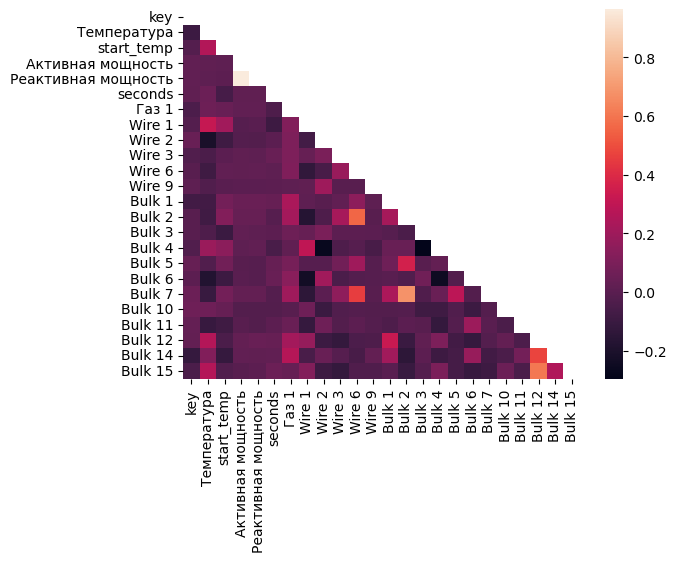

In [35]:
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), mask=matrix)

In [36]:
data = data.drop(['Реактивная мощность'] , axis=1)

In [37]:
data = data.drop(['key'] , axis=1)

In [38]:
data.loc[(data['Температура'] < 1600) & (data['start_temp'] < 1600)]
data = data.reset_index(drop=True)

In [39]:
data

**Вывод**

Исходя из того, что наблюдается очень сильная корелляция между активной и реактивной мощностью, было принято удалить столбец с реактивной мощностью. 

Также следует отметить то, что предобработка данных проведена и данные объединены, поэтому столбец со значением key больше не нужен и его можно удалить.

Также были отброшены строки со значением температуры ниже значения температуры плавления.

# Работа с моделью машинного обучения

**Разделение на тестовую и обучающую выборки**

In [67]:
target = data['Температура']
features = data.drop(['Температура'] , axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=140823)

**Обучение моделей c использованием кросс-валидации**

In [68]:
sample_size = int(len(target_train)/3)
dict_of_results = {'best_result': [],
                  'best_est': [],
                  'best_depth': []}

for i in range(0, len(target_train), sample_size):
    valid_indexes = features_train.iloc[i: i + sample_size].index
    train_indexes = features_train.loc[features_train.index.isin(valid_indexes) == False].index
    
    features_train_val = features_train.loc[train_indexes]
    target_train_val = target_train.loc[train_indexes]
    features_valid = features_train.loc[valid_indexes]
    target_valid = target_train.loc[valid_indexes]
    
    best_result = 8
    best_est = 0
    best_depth = 0

    for est in range(10, 101, 10):
        for depth in range (1, 15, 1):
            model_forest = RandomForestRegressor(random_state=140823, n_estimators=est, max_depth=depth)
            model_forest.fit(features_train_val, target_train_val) 
        
            predictions_valid = model_forest.predict(features_valid) 
            result = mean_absolute_error(target_valid, predictions_valid)

            if result < best_result:
                best_result = result
                best_est = est
                best_depth = depth
    
    dict_of_results['best_result'].append(best_result)
    dict_of_results['best_est'].append(best_est)
    dict_of_results['best_depth'].append(best_depth)
    
    print(best_result)
    print(best_est)
    print(best_depth)

In [69]:
sample_size = int(len(target_train)/3)
dict_of_results_1 = {'best_result': [],
                  'best_est': [],
                  'best_leave': []}

for i in range(0, len(target_train), sample_size):
    valid_indexes = features_train.iloc[i: i + sample_size].index
    train_indexes = features_train.loc[features_train.index.isin(valid_indexes) == False].index
    
    features_train_val = features_train.loc[train_indexes]
    target_train_val = target_train.loc[train_indexes]
    features_valid = features_train.loc[valid_indexes]
    target_valid = target_train.loc[valid_indexes]
    
    best_result = 8
    best_est = 0
    best_leave = 0

    for est in range(10, 70, 10):
        for leave in range (10, 50, 5):
            model_lgbr = ltb.LGBMRegressor(random_seed=140823, n_estimators=est, num_leaves=leave)
            model_lgbr.fit(features_train_val, target_train_val) 
        
            predictions_valid = model_lgbr.predict(features_valid) 
            result = mean_absolute_error(target_valid, predictions_valid)

            if result < best_result:
                best_result = result
                best_est = est
                best_leave = leave
    
    dict_of_results_1['best_result'].append(best_result)
    dict_of_results_1['best_est'].append(best_est)
    dict_of_results_1['best_leave'].append(best_leave)
    
    print(best_result)
    print(best_est)
    print(best_leave)

In [70]:
sample_size = int(len(target_train)/3)
dict_of_results_2 = {'best_result': [],
                  'best_depth': []}

for i in range(0, len(target_train), sample_size):
    valid_indexes = features_train.iloc[i: i + sample_size].index
    train_indexes = features_train.loc[features_train.index.isin(valid_indexes) == False].index
    
    features_train_val = features_train.loc[train_indexes]
    target_train_val = target_train.loc[train_indexes]
    features_valid = features_train.loc[valid_indexes]
    target_valid = target_train.loc[valid_indexes]
    
    best_result = 8
    best_depth = 0

    for depth in range(1, 15, 1):
        model_tree = DecisionTreeRegressor(random_state=140823, max_depth=depth)
        model_tree.fit(features_train_val, target_train_val) 
        
        predictions_valid = model_tree.predict(features_valid) 
        result = mean_absolute_error(target_valid, predictions_valid)

        if result < best_result:
            best_result = result
            best_depth = depth
    
    dict_of_results_2['best_result'].append(best_result)
    dict_of_results_2['best_depth'].append(best_depth)
    
    print(best_result)
    print(best_depth)

**Вывод**

Лучше всего показала себя модель LGBM.

**Автоматический подбор параметров**

In [99]:
parametrs = { 'n_estimators': [i for i in range (10, 101, 10)],
              'num_leaves': [i for i in range (10, 51, 5)],
              'max_depth': [i for i in range (10, 36, 5)],
              'learning_rate': [0.1, 0.01],
              'random_state' : [140823]}

In [100]:
model_lgbr = ltb.LGBMRegressor()

grid = GridSearchCV(model_lgbr, parametrs, cv=3)
grid.fit(features_train, target_train)

In [102]:
grid.best_params_

**Проверка на тестовой выборке**

In [103]:
target = data['Температура']
features = data.drop(['Температура'] , axis=1)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=140823)

**Масштабирование**

In [104]:
scaler = StandardScaler()
scaler.fit(features_train)
features_train_scale = scaler.transform(features_train)
features_test_scale = scaler.transform(features_test)

In [110]:
model_lgbr = ltb.LGBMRegressor(random_seed=140823, n_estimators=30, num_leaves=25, max_depth = 30, learning_rate=0.1)
model_lgbr.fit(features_train_scale, target_train) 
        
predictions_test = model_lgbr.predict(features_test_scale) 
result = mean_absolute_error(target_test, predictions_test)
result

**Сравнение с константной моделью**

In [106]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(features_train, target_train)
dummy_pred = dummy_regr.predict(features_test)
result = mean_absolute_error(target_test, dummy_pred)
result

**Исследование на признаки**

In [107]:
features_test_inverse = pd.DataFrame(scaler.inverse_transform(features_test),
                              columns = features_test.columns)

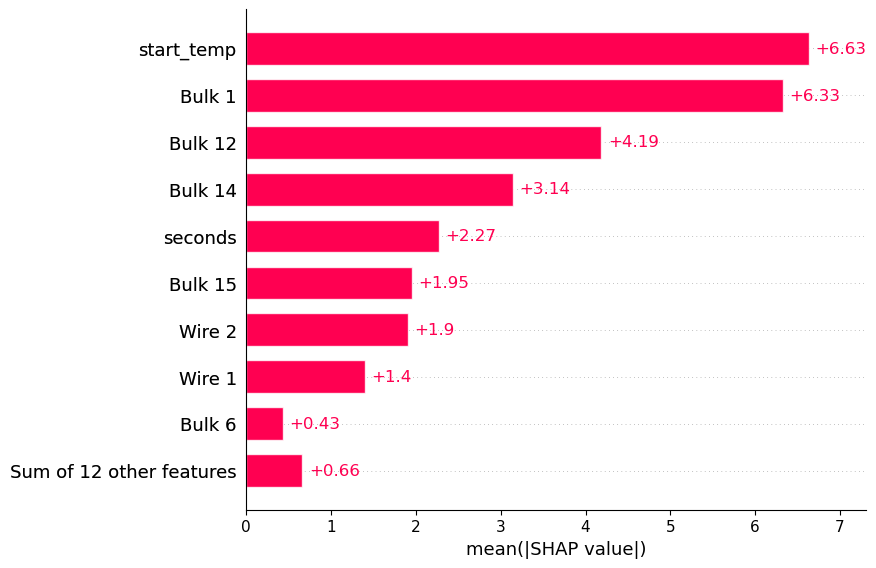

In [108]:
explainer = shap.Explainer(model_lgbr)
shap_values = explainer(features_test_inverse)
shap.plots.bar(shap_values)

**Вывод**

При исследовании признаков после обучения был сделан вывод о том, что наиболее полезным принаком при обучении модели является начальная температура партии, также данные о некоторых присадках и время процесса плавки.

# Вывод

В ходе решения задачи было проанализировано неколько моделей машинного обучения, среди них: модель обучающего дерева модель леса деревьев, а также модель градиентного бустинга. Все модели были проверены при помощи кросс-валидации на тренировочных выборках.

Лучше всего с задачей предсказания финальной температуры справляется модель LGBM, гиперпараметры модели составили n_estimators=30, num_leaves=25, max_depth = 30, learning_rate=0.1, random_seed=140823. Итоговое значение метрики MAE составило 6,62, что удовлеторяет запросу заказчика.

Также модель была сравнена с константной, был сделан вывод о том, что она лучше константной предсказывает температуру на 1,5 градуса.

# Отчет

**Трудности**

В ходе работы над проектом возникли следующие трудности: 

1) Изначально было непонятно каким образом объединить данные. В ходе работы над проектом был получен комментарий тимлида: по ключу;

2) Также непонятно было, какую метрику использовать для оценки модели. Также в ходе работы над проектом был получен комментарий от тимлида по этому поводу: метрику MAE;

3) Также были вопросы по поводу касательно обработки пропусков в данных и аномалий. Данный вопрос был также уточнен тимлидом.


**Исследовательский анализ данных**

Был проведен первоначальный анализ данных. В его процессе были выполнены следующие пункты:

1) Была произведена загрузка и изучение данных;

2) Были удалены аномалии в датафреймах с температурой (температуры, выше температуры плавления) и мощностью (отрицательная реактивная мощность);

3) Была произведена первоначальная предобработка. Столбцы с датой и временем были заменены на общее время процесса плавки. Удалена реактивная мощность, так как она обладала коллинеарностью с активной мощностью. Также были удалены столбцы с объемами  тех легирующих элементов, которые практически не использовались в процессе плавки;

4) Было произведено объединение датафреймов с температурой, объемами легирующих веществ, активной мощностью, газом. Объединение было произведено по ключу партии. Объединение было произведено при помощи метода merge (inner);

5) После этого были удалены строки в которых есть пропуски (в столбцах с температурой, мощнолстью и временем процесса). Также был удален столбец со значением ключа номера партии;

6) Итоговый датафрейм состоял из следующих столбцов: время процесса плавки, первоначальная температура, активная мощность, газ, а также объемы легирующих элементов, конечная температура (целевой признак).

**Машинное обучение**

1) Далее датафрейм был разбит на признаки для обучения и целевой признак (финальная температура). Соотношение между тестовой и обучающей выборкой составило 1:3;

2) Далее вручную была проведена кросс-валидация. Тренировочная выборка была разделена 1:2. Кросс-валидация проводилась на следующих моделях машинного обучения: RandomForestRegressor, DecisionTreeRegressor и LigtGBM. Лучше всего показала себя модель машинного обучения LGBM, наилучший результат по ней составил 6.97;

3) Далее была проведена автоматическая кросс-валидация с подбором параметров уже только на модели LGBM при помощи метода GridSearchCV;

4) Далее были промасштабированы признаки для обучения тестовой и тренировочной выборки;

5) Модель LGBM была заново обучена целиком на тренировочной выборке и показала результат на метрике MAE 6,62, что удовлетворяет требованиям заказчика. Гиперпараметры модели следующие:  n_estimators=30, num_leaves=25, max_depth = 30, learning_rate=0.1, random_seed=140823;

6) Далее была создана константная модель, предсказывающая среднее по всему датафрейму значение финальной температуры. Значение метрики MAE составило 8, что является более плохим результатом по сравнению с моделью LGBM на 1.4 градуса;

7) Далее было произведено SHAP исследование, с помощью которого были выявлены наиболее важные для обучения модели признаки. Исследование показало, что наиболее полезным принаком при обучении модели является начальная температура партии, также данные о некоторых присадках и время процесса плавки.